## U-Net avec/sans skip connections  
Comparaison de 2 modèles UNet et UnetNoSkip pour voir l'apport des skip connections.  
Ce modèle travaille sur l'espace de couleurs Lab.  
Entrée = L ; Sortie : a et b prédits.  
Reconversion au format RGB pour l'affichage.  
Entraînement sous Google Colab (T4 GPU ~20min/epoch)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips

/home/greg7/S9/env/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Modèle avec skip connections

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.final = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        # Middle
        middle = self.middle(enc2_pool)
        
        # Decoder
        up2 = self.up2(middle)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        
        out = self.final(dec1)
        
        return out

### Modèle sans skip connections

In [51]:
class UNetNoSkip(nn.Module):
    def __init__(self):
        super(UNetNoSkip, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Final layer
        self.final = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        # Middle
        middle = self.middle(enc2_pool)
        
        # Decoder
        up2 = self.up2(middle)
        dec2 = self.dec2(up2)

        up1 = self.up1(dec2)
        dec1 = self.dec1(up1)
        
        # Final layer
        out = self.final(dec1)
        
        return out

In [52]:
# Convertir les images RGB en Lab
class RGBToLab:
    def __call__(self, img):
        img = np.array(img)
        lab_img = Image.fromarray(img).convert("LAB")
        return lab_img

In [53]:
# Extraction des canaux L, a et b
class LabToTensor:
    def __call__(self, img):
        img = np.array(img)
        img = img.astype(np.float32) / 255.0
        img = (img - 0.5) * 2  # Normalisation
        L = img[..., 0:1]
        a_b = img[..., 1:]
        L = torch.from_numpy(L).permute(2, 0, 1)
        a_b = torch.from_numpy(a_b).permute(2, 0, 1)
        return L, a_b

In [54]:
# Préparation du dataset CIFAR-10
transform = transforms.Compose([
    RGBToLab(),
    LabToTensor()
])

class LabCIFAR10(datasets.CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        L, a_b = transform(img)
        return L, a_b

train_dataset = LabCIFAR10(root='./data', train=True, download=True)
test_dataset = LabCIFAR10(root='./data', train=False, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [55]:
# Fonction d'entraînement
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for L, a_b in train_loader:
            L, a_b = L.cuda(), a_b.cuda()
            
            optimizer.zero_grad()
            outputs = model(L)
            loss = criterion(outputs, a_b)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * L.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

In [56]:
# Fonction de validation
def validate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for L, a_b in test_loader:
            L, a_b = L.cuda(), a_b.cuda()
            
            outputs = model(L)
            loss = criterion(outputs, a_b)
            
            val_loss += loss.item() * L.size(0)
    
    val_loss /= len(test_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}')

### Cellule à executer avec GPU

In [68]:
# Entraînement sous Google Colab
# model = UNet().cuda()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# train_model(model, train_loader, criterion, optimizer, num_epochs=1) # a augmenter pour la suite 

# validate_model(model, test_loader, criterion)

# Sauvegarder les poids du modèle
# torch.save(model.state_dict(), 'unet_skip_cifar10.pth')

# Télécharger les poids du modèle
# from google.colab import files
# files.download('unet_skip_cifar10.pth')

### Chargement des poids du modèle (entraînement fait sous Google Colab)

In [ ]:
# Decommenter le modèle a tester 
model = UNet()
model.load_state_dict(torch.load('unet_skip_cifar10.pth', map_location=torch.device('cpu')))

# model = UNetNoSkip()
# model.load_state_dict(torch.load('unet_no_skip_cifar10.pth', map_location=torch.device('cpu')))

model.eval()

In [59]:
def get_test_images(test_loader, num_images=5):
    test_images = []
    test_labels = []
    for L, a_b in test_loader:
        test_images.extend(L[:num_images])
        test_labels.extend(a_b[:num_images])
        if len(test_images) >= num_images:
            break
    return torch.stack(test_images), torch.stack(test_labels)

num_test_images = 5
test_images, test_labels = get_test_images(test_loader, num_images=num_test_images)

In [44]:
with torch.no_grad():
    predicted_ab = model(test_images.cpu())

In [60]:
def lab_to_rgb(L, ab):
    L = L.transpose((1, 2, 0))
    ab = ab.transpose((1, 2, 0))
    Lab = np.concatenate((L, ab), axis=2)
    Lab = (Lab + 1) / 2 * 255  # Dé-normaliser
    Lab = Lab.astype(np.uint8)
    Lab = Image.fromarray(Lab, mode='LAB')
    rgb_img = Lab.convert('RGB')
    return np.array(rgb_img)

# Convertir les images de test et les prédictions en RGB
rgb_originals = []
rgb_predictions = []

for i in range(num_test_images):
    L = test_images[i].cpu().numpy()
    ab = test_labels[i].cpu().numpy()
    pred_ab = predicted_ab[i].cpu().numpy()
    
    L = (L + 1) / 2 * 255  # Dé-normaliser
    L = L.astype(np.uint8)
    
    original_rgb = lab_to_rgb(L, ab)
    predicted_rgb = lab_to_rgb(L, pred_ab)
    
    rgb_originals.append(original_rgb)
    rgb_predictions.append(predicted_rgb)

In [47]:
# Calcul des métriques (EN COURS)
# mse_list = []
# mae_list = []
# psnr_list = []
# ssim_list = []
# lpips_model = lpips.LPIPS(net='alex')  # LPIPS Model
# lpips_list = []

# for i in range(num_test_images):
#     original_rgb = rgb_originals[i].astype(np.float32) / 255.0
#     predicted_rgb = rgb_predictions[i].astype(np.float32) / 255.0
    
#     mse = mean_squared_error(original_rgb, predicted_rgb)
#     mae = mean_absolute_error(original_rgb, predicted_rgb)
#     psnr = peak_signal_noise_ratio(original_rgb, predicted_rgb, data_range=1)
#     ssim = structural_similarity(original_rgb, predicted_rgb, multichannel=True, data_range=1)
    
#     original_rgb_tensor = torch.from_numpy(original_rgb).permute(2, 0, 1).unsqueeze(0).cuda()
#     predicted_rgb_tensor = torch.from_numpy(predicted_rgb).permute(2, 0, 1).unsqueeze(0).cuda()
#     lpips_score = lpips_model(original_rgb_tensor, predicted_rgb_tensor).item()
    
#     mse_list.append(mse)
#     mae_list.append(mae)
#     psnr_list.append(psnr)
#     ssim_list.append(ssim)
#     lpips_list.append(lpips_score)

In [48]:
# Affichage des métriques ((EN COURS)
# print("Métriques d'évaluation:")
# print(f"MSE: {np.mean(mse_list):.4f}")
# print(f"MAE: {np.mean(mae_list):.4f}")
# print(f"PSNR: {np.mean(psnr_list):.4f}")
# print(f"SSIM: {np.mean(ssim_list):.4f}")
# print(f"LPIPS: {np.mean(lpips_list):.4f}")

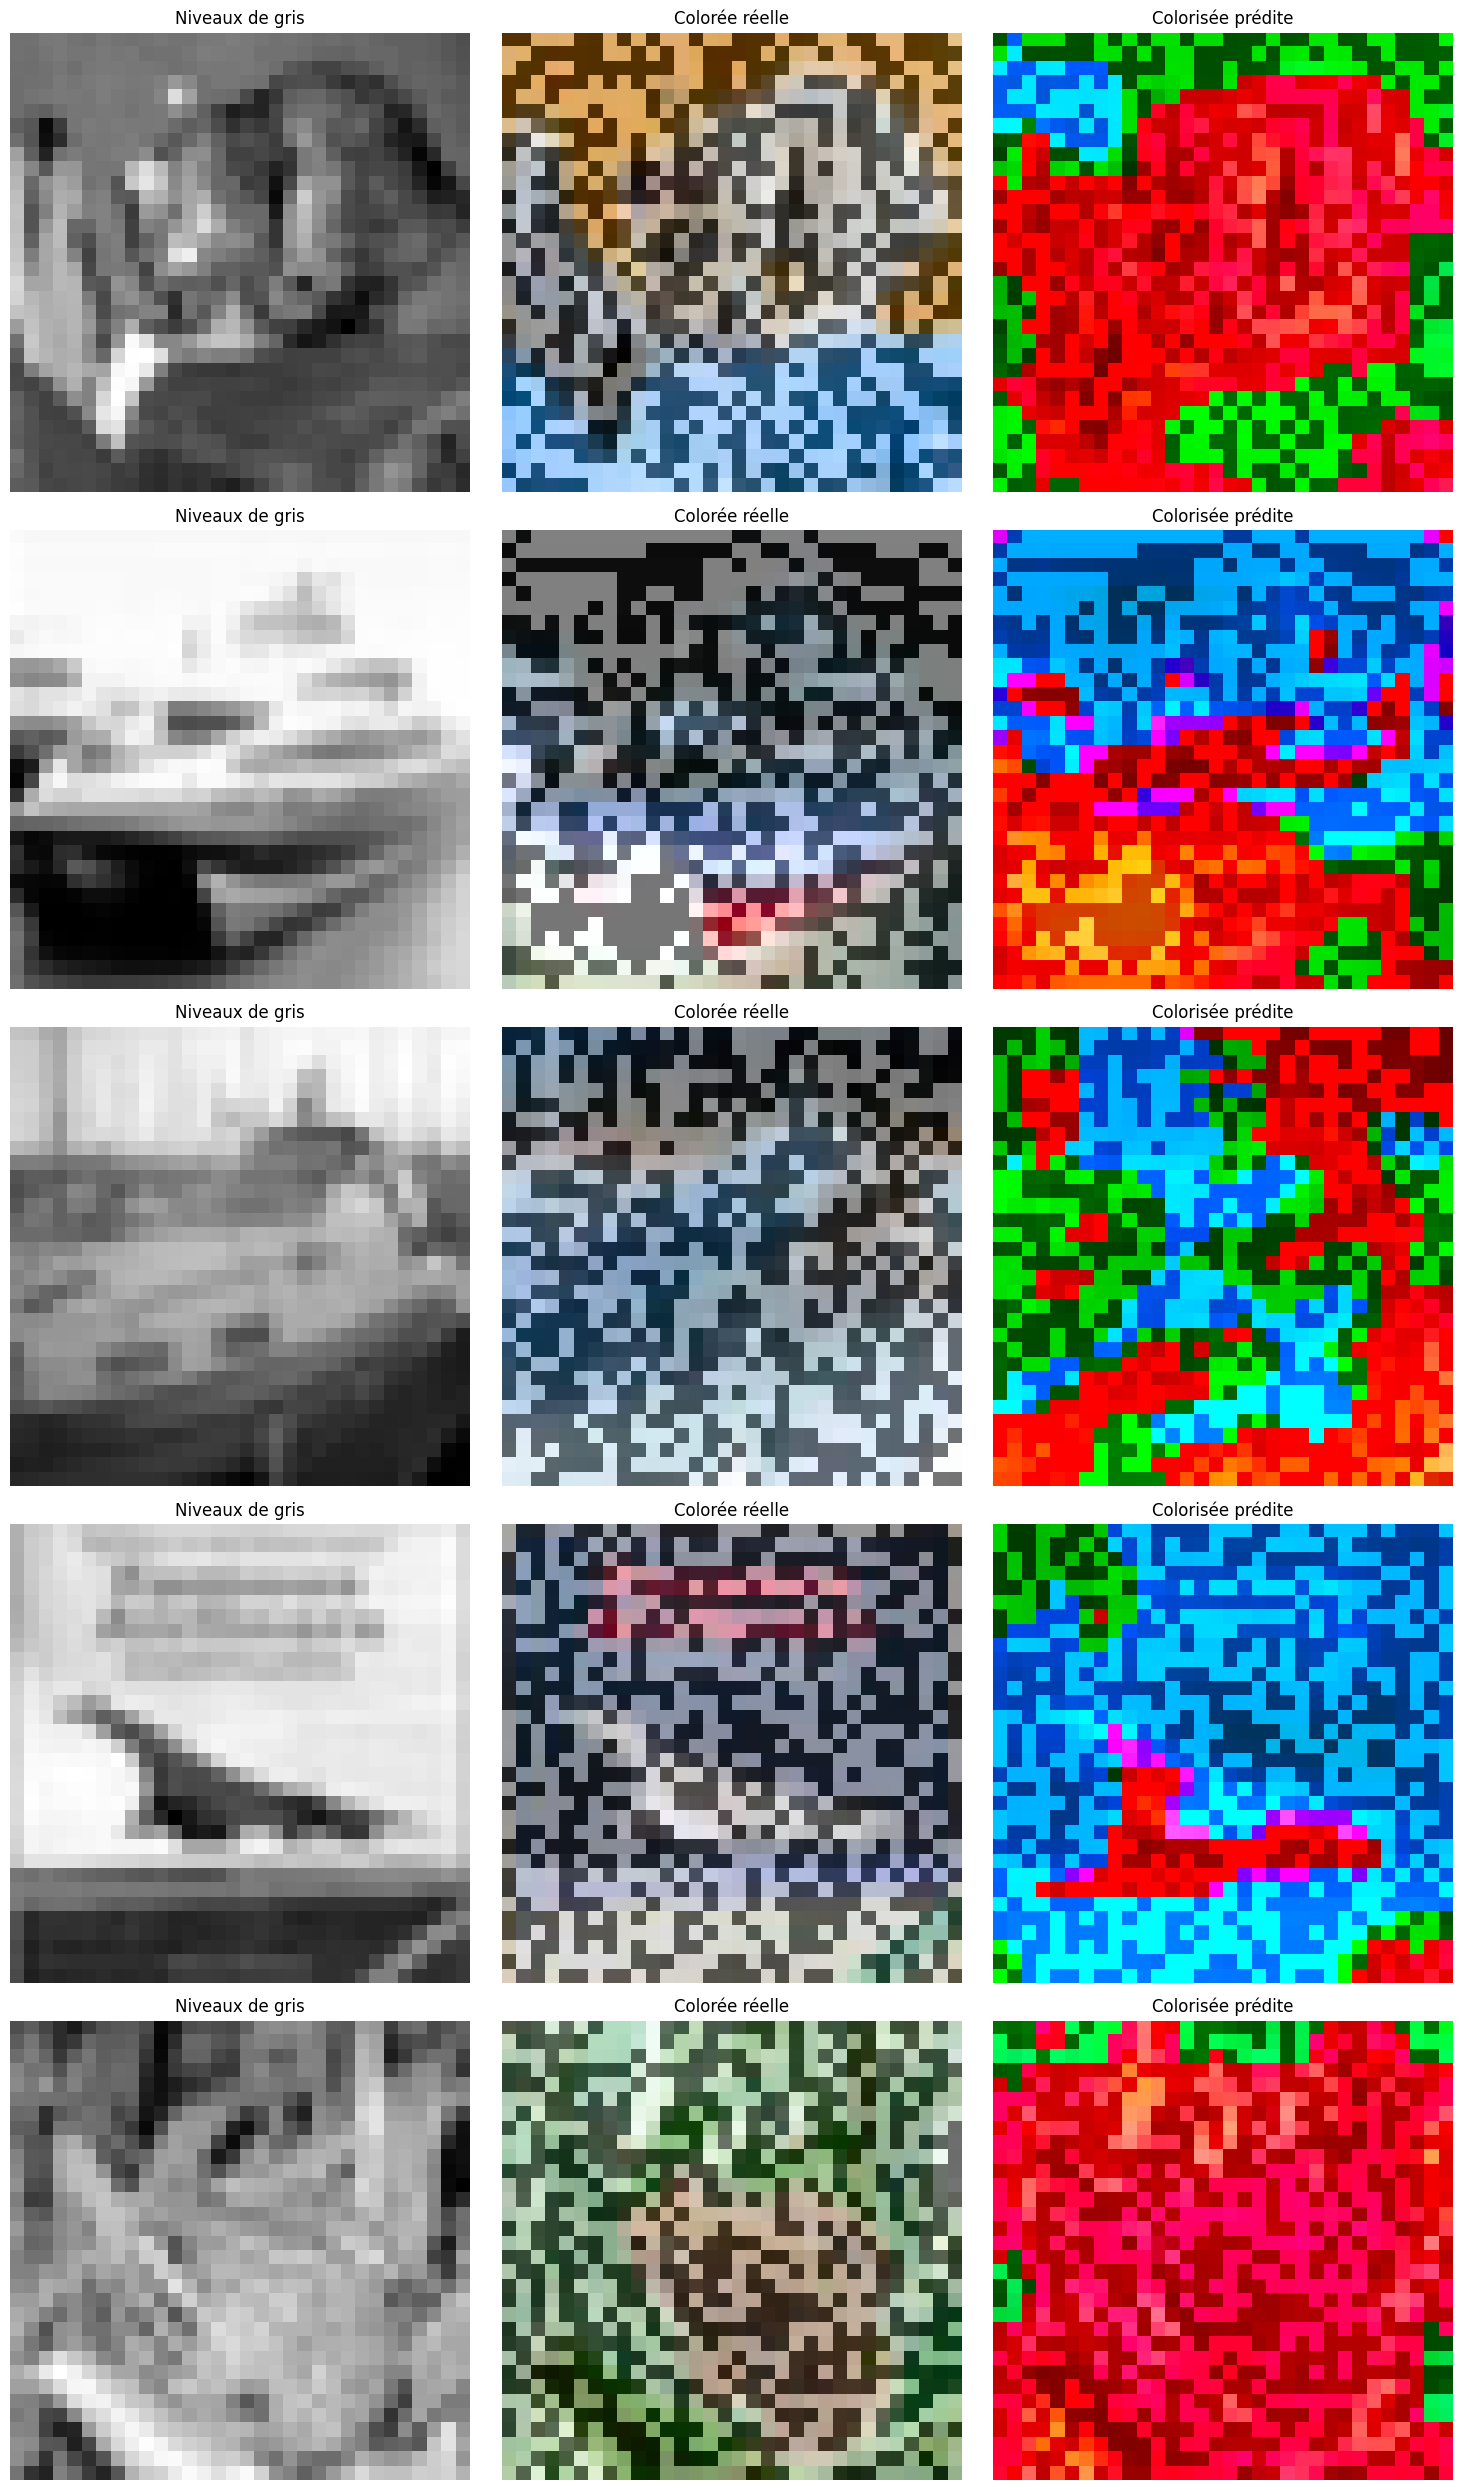

In [46]:
# Afficher les résultats sous forme de tableau
fig, axes = plt.subplots(num_test_images, 3, figsize=(15, 5 * num_test_images))

for i in range(num_test_images):
    L_img = test_images[i].cpu().numpy().transpose((1, 2, 0))
    L_img = (L_img + 1) / 2 * 255  # Dé-normaliser
    L_img = L_img.astype(np.uint8).squeeze()  # Retirer le canal unique pour l'affichage en niveaux de gris
    
    axes[i, 0].imshow(L_img, cmap='gray')
    axes[i, 0].set_title('Niveaux de gris')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(rgb_originals[i])
    axes[i, 1].set_title('Colorée réelle')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(rgb_predictions[i])
    axes[i, 2].set_title('Colorisée prédite')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('results/UNetskip.png', format='png')
plt.show()